# Libraries and Dataset setup

In [1]:
# Downloaded data from https://www.kaggle.com/c/titanic/data
# "kaggle competitions download -c titanic"
import os
import pandas as pd
import numpy as np
import csv

%matplotlib inline
import matplotlib.pyplot as plt

TITANIC_PATH = os.path.join("datasets", "titanic")

def load_titanic_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

# Create submission file with assigned predicted results from models
def create_file_for_submission(filename, classifier_predictions):
    
    classifier_predictions = np.reshape(classifier_predictions, (classifier_predictions.shape[0], 1))
    print("The reshape of Prediction numpy array : ", classifier_predictions.shape)

    classifier_predicted_results = np.concatenate((passengerID, classifier_predictions), axis=1)
    print("The concatenation of PassengerId and Prediction numpy arrays  : ", classifier_predicted_results.shape)

    print("For PassengerIds : ", classifier_predicted_results[0:10,0])
    print("The respective predicted results : ", classifier_predicted_results[0:10,1])
    
    # Create and overwrite existing file
    with open('datasets/titanic/' + filename, 'w') as writeFile:
        filewriter = csv.writer(writeFile, delimiter=',',
                                quotechar='|', quoting=csv.QUOTE_MINIMAL)
        filewriter.writerow(['PassengerId', 'Survived'])

        iteration_range = classifier_predicted_results.shape[0]
        for i in range(iteration_range):
            filewriter.writerow([str(classifier_predicted_results[i,0]), str(classifier_predicted_results[i,1])])
        #np.savetxt(writeFile, model_predicted_results[0:10], delimiter=",") gives decimals

    writeFile.close()

In [2]:
# Loading the respective Train and Test data
train_data = load_titanic_data("train.csv")
test_data = load_titanic_data("test.csv")

len(train_data), len(test_data)

(891, 418)

In [3]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


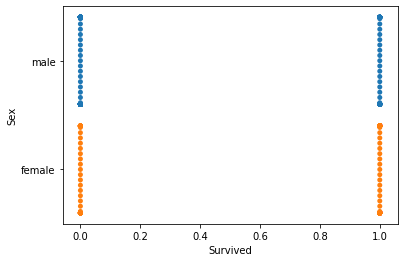

In [4]:
import seaborn as sns

sns.swarmplot(x=train_data['Survived'], y=train_data['Sex'])

In [5]:
# To create a new column with initial value '0', avoid the "SettingWithCopyWarning" when setting the values to int
test_data['Survived'] = 0
test_data.head()

# Merge train and test with append that creates float values for "Survived" column if values do not exist
titanic_merged_data = train_data.append(test_data, ignore_index=True, sort=False)

# create indexes to separate data later on
train_data_idx = len(train_data) # 891
test_data_idx = len(titanic_merged_data) - len(test_data) # 891

# Create a new feature to extract title names from the Name column
titanic_merged_data['Title'] = titanic_merged_data.Name.apply(lambda name: name.split(',')[1].split('.')[0].strip())

# Show value counts for the different titles
print(titanic_merged_data.Title.value_counts())

Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Ms                2
Mlle              2
Major             2
Don               1
Capt              1
Lady              1
Mme               1
Jonkheer          1
the Countess      1
Dona              1
Sir               1
Name: Title, dtype: int64


In [6]:
# Normalize the titles
normalized_titles = {
    "Capt":       "Officer",
    "Col":        "Officer",
    "Major":      "Officer",
    "Jonkheer":   "Royalty",
    "Don":        "Royalty",
    "Sir" :       "Royalty",
    "Dr":         "Officer",
    "Rev":        "Officer",
    "the Countess":"Royalty",
    "Dona":       "Royalty",
    "Mme":        "Mrs",
    "Mlle":       "Miss",
    "Ms":         "Mrs",
    "Mr" :        "Mr",
    "Mrs" :       "Mrs",
    "Miss" :      "Miss",
    "Master" :    "Master",
    "Lady" :      "Royalty"
}

# Map the normalized titles to the current titles 
titanic_merged_data.Title = titanic_merged_data.Title.map(normalized_titles)

# Show value counts for the normalized titles
print(titanic_merged_data.Title.value_counts())

Mr         757
Miss       262
Mrs        200
Master      61
Officer     23
Royalty      6
Name: Title, dtype: int64


In [7]:
titanic_merged_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,Mr
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,Mrs
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,Miss
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,Mrs
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,Mr


In [8]:
# Group by Sex, Pclass, and Title to estimate missing Age
grouped = titanic_merged_data.groupby(['Sex','Pclass', 'Title'])

# Show the median Age by the grouped features 
grouped.Age.median()

Sex     Pclass  Title  
female  1       Miss       30.0
                Mrs        45.0
                Officer    49.0
                Royalty    39.0
        2       Miss       20.0
                Mrs        30.0
        3       Miss       18.0
                Mrs        31.0
male    1       Master      6.0
                Mr         41.5
                Officer    52.0
                Royalty    40.0
        2       Master      2.0
                Mr         30.0
                Officer    41.5
        3       Master      6.0
                Mr         26.0
Name: Age, dtype: float64

In [9]:
# Get a closer approximation of what a passenger’s age might have been from the group by Sex, Pclass, and Title
# Apply the grouped median value on the Age that has the value of NaN
titanic_merged_data.Age = grouped.Age.apply(lambda age: age.fillna(age.median()))

# Before applying Median Age in group
# titanic_merged_data.Age.head(20)
titanic_merged_data.Age.head()

0    22.0
1    38.0
2    26.0
3    35.0
4    35.0
Name: Age, dtype: float64

In [10]:
# Fill Cabin NaN with "U" for unknown
titanic_merged_data.Cabin = titanic_merged_data.Cabin.fillna('U')

# Obtain the most frequent Embarked value and store in a variable, "most_embarked"
most_embarked = titanic_merged_data.Embarked.value_counts().index[0]

# Fill NaN with the value of "most_embarked"
titanic_merged_data.Embarked = titanic_merged_data.Embarked.fillna(most_embarked)

# Fill NaN with the median fare
titanic_merged_data.Fare = titanic_merged_data.Fare.fillna(titanic_merged_data.Fare.median())

# view changes
titanic_merged_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
PassengerId    1309 non-null int64
Survived       1309 non-null int64
Pclass         1309 non-null int64
Name           1309 non-null object
Sex            1309 non-null object
Age            1309 non-null float64
SibSp          1309 non-null int64
Parch          1309 non-null int64
Ticket         1309 non-null object
Fare           1309 non-null float64
Cabin          1309 non-null object
Embarked       1309 non-null object
Title          1309 non-null object
dtypes: float64(2), int64(5), object(6)
memory usage: 133.1+ KB


In [11]:
# Feature Engineering
# Create a new feature for the size of families (including the passenger)
titanic_merged_data['FamilySize'] = titanic_merged_data.Parch + titanic_merged_data.SibSp + 1

#titanic_merged_data['AgeGroup'] = (titanic_merged_data.Age // 15) * 15 + 15 # Set the Age Group

# Map first letter of cabin to itself (section where the room would have been)
titanic_merged_data.Cabin = titanic_merged_data.Cabin.map(lambda cabin: cabin[0])

titanic_merged_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,FamilySize
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,U,S,Mr,2
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C,C,Mrs,2
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,U,S,Miss,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C,S,Mrs,2
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,U,S,Mr,1


In [12]:
# Convert the male and female groups to integer form
titanic_merged_data.Sex = titanic_merged_data.Sex.map({"male": 0, "female": 1})

# Create dummy variables for categorical features
pclass_dummies = pd.get_dummies(titanic_merged_data.Pclass, prefix="Pclass")
title_dummies = pd.get_dummies(titanic_merged_data.Title, prefix="Title")
cabin_dummies = pd.get_dummies(titanic_merged_data.Cabin, prefix="Cabin")
embarked_dummies = pd.get_dummies(titanic_merged_data.Embarked, prefix="Embarked")

# Concatenate dummy columns with main dataset
titanic_merged_data_dummies = pd.concat([titanic_merged_data, pclass_dummies, title_dummies, cabin_dummies, embarked_dummies], axis=1)

# Drop the categorical fields and unused "Ticket", "Name" features
titanic_merged_data_dummies.drop(['Pclass', 'Title', 'Cabin', 'Embarked', 'Name', 'Ticket'], axis=1, inplace=True)

titanic_merged_data_dummies.head()

,PassengerId,Survived,Sex,Age,SibSp,Parch,Fare,FamilySize,Pclass_1,Pclass_2,...,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T,Cabin_U,Embarked_C,Embarked_Q,Embarked_S
0,1,0,0,22.0,1,0,7.2500,2,0,0,...,0,0,0,0,0,0,1,0,0,1
1,2,1,1,38.0,1,0,71.2833,2,1,0,...,1,0,0,0,0,0,0,1,0,0
2,3,1,1,26.0,0,0,7.9250,1,0,0,...,0,0,0,0,0,0,1,0,0,1
3,4,1,1,35.0,1,0,53.1000,2,1,0,...,1,0,0,0,0,0,0,0,0,1
4,5,0,0,35.0,0,0,8.0500,1,0,0,...,0,0,0,0,0,0,1,0,0,1


In [13]:
partial_training_data = pd.DataFrame(titanic_merged_data, columns=
                                     ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'FamilySize'])

partial_training_data.head()

,Survived,Pclass,Sex,Age,Fare,FamilySize
0,0,3,0,22.0,7.2500,2
1,1,1,1,38.0,71.2833,2
2,1,3,1,26.0,7.9250,1
3,1,1,1,35.0,53.1000,2
4,0,3,0,35.0,8.0500,1


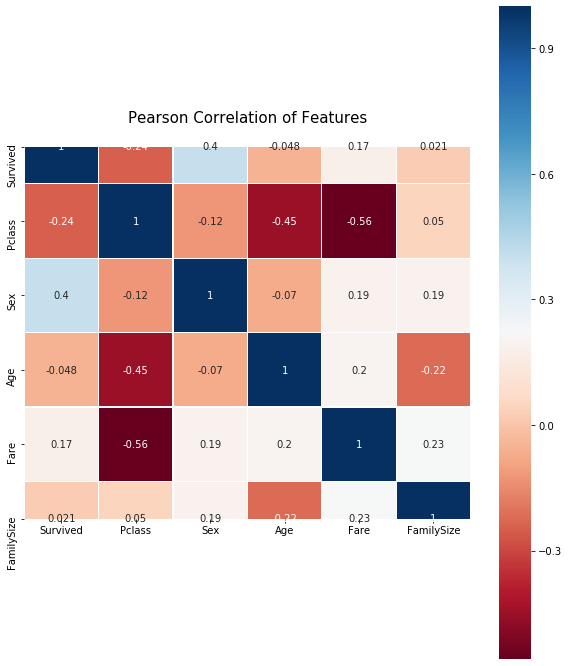

In [14]:
colormap = plt.cm.RdBu
plt.figure(figsize=(10,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(partial_training_data.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [15]:
# save PassengerId for final submission
passengerId = test_data.PassengerId
# Convert from DataFrames to Numpy Array
passengerID = test_data['PassengerId'].values # get from DataFrame to Numpy Array
passengerID = np.reshape(passengerID, (passengerID.shape[0], 1))

# Create the train and test data for training and prediction
X_train = titanic_merged_data_dummies[ :train_data_idx] # need to have leading space
X_test = titanic_merged_data_dummies[test_data_idx: ]   # need to have trailing space

# Convert "Survived" back to int
#X_train.Survived = X_train.Survived.astype(int)

X_train.head()
# Create X and y for data and ground truth label values
y_train = X_train.Survived.values
X_train = X_train.drop('Survived', axis=1).values 

# create array for test set
X_test = X_test.drop('Survived', axis=1).values

X_train.shape, y_train.shape, passengerId.shape, passengerID.shape

((891, 28), (891,), (418,), (418, 1))

# XGBoost Classifiers and Predictions
- <B>XGradient Boost Random Forest Classifier</B>

In [ ]:
from sklearn import preprocessing
import xgboost as xgb

xgbrf_Classifier = xgb.XGBRFClassifier(n_estimators=500,
                        n_jobs=4,
                        max_depth=9,
                        learning_rate=0.05,
                        subsample=0.9,
                        colsample_bytree=0.9,
                        missing=-999)

xgbrf_Classifier.fit(X_train, y_train)

In [ ]:
# Returns the mean accuracy on the given test data and labels
xgbrf_Classifier.score(X_train, y_train)

# xgb_RFClassifier gives 0.9068462401795735
# xgb_Classifier gives 1.0

In [ ]:
xgbrf_predictions = xgbrf_Classifier.predict(X_test)

# dataframe with predictions
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': xgbrf_predictions})
# save to csv
kaggle.to_csv('./datasets/titanic/xgbrf_classifier.csv', index=False)

#passengerId.shape, xgb_predictions.shape give ((418,), (418,))
xgbrf_predictions.shape

In [ ]:
xgbrf_Classifier.get_params().keys()

In [ ]:
# Search the best combination of hyperparameter values
from sklearn.model_selection import GridSearchCV

kfold=3

colsample_bytrees = [0.9, 0.95]
gammas = [0.001, 0.01, 0.1, 1]
learning_rates = [0.05, 0.10]
max_depths = [9, 10]
missings = [0, -999]
n_estimators = [100, 200]
subsamples = [0.9, 0.95]

xbgrf_classifier_param_grid = {'colsample_bytree': colsample_bytrees, 'gamma': gammas,
                               'learning_rate': learning_rates, 'max_depth': max_depths,
                               'missing': missings, 'n_estimators': n_estimators,
                               'subsample': subsamples}

# Tuning the param for GridSearch and performance has been increased to approx. 83.056% 
grid_search = GridSearchCV(xgbrf_Classifier, xbgrf_classifier_param_grid,
                           cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)

grid_search.fit(X_train, y_train)
grid_search.best_params_

In [ ]:
# Using GridSearchCV to obtain final model with best estimator
best_xgbrf_classifier_model = grid_search.best_estimator_
best_xgbrf_classifier_model

In [ ]:
best_xgbrf_classifier_model.score(X_train, y_train)

# 0.9057239057239057

In [ ]:
# Using Cross Validation to check the performance of XGB Random Forest Classifier
from sklearn.model_selection import cross_val_score

best_xgbrf_classifier_scores = cross_val_score(best_xgbrf_classifier_model, X_train, y_train, cv=10)
best_xgbrf_classifier_scores.mean()

# 0.8305575417092271

In [ ]:
best_xgbrf_predictions = best_xgbrf_classifier_model.predict(X_test)
best_xgbrf_predictions.shape

In [ ]:
# dataframe with predictions
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': best_xgbrf_predictions})
# save to csv
kaggle.to_csv('./datasets/titanic/best_xgbrf_classifier.csv', index=False)

# Begin : Partial Test with RandomForestClassifier

In [ ]:
# create param grid object 
forrest_params = dict(     
    max_depth = [n 
for n in range(9, 14)],     
    min_samples_split = [n 
for n in range(4, 11)], 
    min_samples_leaf = [n 
for n in range(2, 5)],     
    n_estimators = [n 
for n in range(10, 60, 10)],
)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# instantiate Random Forest model
forrest = RandomForestClassifier()

# build and fit model 
forest_cv = GridSearchCV(estimator=forrest, param_grid=forrest_params, cv=10) 
forest_cv.fit(X_train, y_train)

In [ ]:
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

In [ ]:
# random forrest prediction on test set
forrest_pred = forest_cv.predict(X_test)

In [ ]:
passengerId.shape, forrest_pred.shape

In [ ]:
# dataframe with predictions
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': forrest_pred})
# save to csv
kaggle.to_csv('./datasets/titanic/titanic_pred.csv', index=False)

# End : Partial Test with RandomForestClassifier

In [ ]:
train_data.info()

In [ ]:
train_data.describe()

In [ ]:
# plot number data
%matplotlib inline
import matplotlib.pyplot as plt
train_data.hist(bins=50, figsize=(20,15))
plt.show()

In [ ]:
from pandas.plotting import scatter_matrix

attributes = ["Survived", "Pclass", "Fare", "Age"]
scatter_matrix(train_data[attributes], figsize=(18,8))
plt.show()

# Building preprocessing pipelines
Selecting numerical and non-numerical attributes from DataFrame

In [ ]:
# Custom Transformer to feed a Pandas DataFrame containing non-numerical columns directly into a pipeline
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self # do nothing
    def transform(self, X):
        return X[self.attribute_names]

# Create new categorical data

In [ ]:
# Custom Transformers
from sklearn.base import BaseEstimator, TransformerMixin

# set the variables with respective index values of matrix X that starts from zero
age_index, SibSp_index, Parch_index = 1, 2, 3

# Value X is taken from param in class_instance.transform(param) 
class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self): # no *args or **kargs
        return None # do nothing
    def fit(self, X, y=None):
        return self # do nothing
    def transform(self, X, y=None):
        Age_group = (X[:, age_index] // 15) * 15 # computed for all rows
        Relatives_onboard = X[:, SibSp_index] + X[:, Parch_index]
        # Added 2 attributes to X
        return np.c_[X, Age_group, Relatives_onboard]

# num_training_data.values[:,1] // 15
attributes_adder = CombinedAttributesAdder()

In [ ]:
# Feature Scaling with StandardScaler from Scikit-Learn
# Transformation Numerical Pipeline and Compute median values to take care of the missing values in the training set
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# StandardScaler subtracts mean and divide by standard deviation giving unit variance
selector_num_pipeline = Pipeline([
    ('selector', DataFrameSelector(["Age", "SibSp", "Parch", "Fare"])),
    ('imputer', SimpleImputer(strategy="median")),
    #('attributes_adder', CombinedAttributesAdder()), # add attributes
    ('std_scaler', StandardScaler()) # Scaling for better performance
])

# Fit the SimpleImputer instance into the training data using fit() method
X = selector_num_pipeline.fit_transform(train_data)

In [ ]:
# Age (float64), SibSp (int64), Parch (int64), Parch (int64)
# X is a plain NumPy array containing the transformed features
# Put X into a Pandas DataFrame
num_training_data = pd.DataFrame(X, columns=["Age", "SibSp", "Parch", "Fare"])
#num_training_data = pd.DataFrame(X, columns=["Age", "SibSp", "Parch", "Fare", "Age_group", "Relatives_onboard"])

# Missing Age values are filled up with median values
num_training_data.info()


In [ ]:
#train_data.columns gives ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
#                          'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']
# Fill NA/NaN values with most frequent values in each column

class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        # Panda Series Constructor that gives a One-dimensional ndarray with column names as axis labels
        # X[col].value_counts().index[0] gives the element with highest value giving most frequent value
        # For loop runs through all columns in the provided data, X
        self.most_frequent_ = pd.Series([X[col].value_counts().index[0] for col in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [ ]:
from sklearn.preprocessing import OneHotEncoder

# Pclass (int64), Sex (object), Embarked (object)
selector_category_pipeline = Pipeline([
    ('selector', DataFrameSelector(["Pclass", "Sex", "Embarked"])),
    ("imputer", MostFrequentImputer()),
    ('category_encoder', OneHotEncoder(categories='auto', sparse=False)),
])

print("Transforming with train data including non-numerical ...")
cleanedfeatures_train_category = selector_category_pipeline.fit_transform(train_data)

# Display transformed categories
cleanedfeatures_train_category[:10]

Preprocessing pipeline that takes the raw data and outputs numerical input features that can be fed to any Machine Learning model

In [ ]:
# Joining pipelines with FeatureUnion
from sklearn.pipeline import FeatureUnion

complete_preprocess_pipeline = FeatureUnion(transformer_list=[
    ("number_pipeline", selector_num_pipeline),
    ("category_pipeline", selector_category_pipeline),
])

X_train = complete_preprocess_pipeline.fit_transform(train_data)

print("The shape of prepared data features : ", X_train.shape)
X_train[:3]

In [ ]:
# Extracting the label from training data
y_train = train_data["Survived"]
print("The shape of labels : ", y_train.shape)

In [ ]:
# Convert from DataFrames to Numpy Array
passengerID = test_data['PassengerId'].values # get from DataFrame to Numpy Array
passengerID = np.reshape(passengerID, (passengerID.shape[0], 1))

# Stochastic Gradient Descent (SGD)

In [ ]:
from sklearn.linear_model import SGDClassifier

# Using Cross Validation to check the performance of Stochastic Gradient Descent
from sklearn.model_selection import cross_val_score

# SGD with l2 regularization
sgd_classifier = SGDClassifier(max_iter=5, tol=-np.infty, random_state=42, penalty='l2')
sgd_classifier.fit(X_train, y_train)

sgd_scores = cross_val_score(sgd_classifier, X_train, y_train, cv=10)
sgd_scores.mean()

# Logistic Regression model

In [ ]:
from sklearn.linear_model import LogisticRegression

logistic_reg = LogisticRegression(solver="liblinear", random_state=42) # lbfgs
logistic_reg.fit(X_train, y_train)

logistic_reg_scores = cross_val_score(logistic_reg, X_train, y_train, cv=10)
logistic_reg_scores.mean()

# Support Vector Machine

In [ ]:
from sklearn.svm import SVC
from sklearn.svm import LinearSVC

# svm_classifier = SVC(gamma="auto")
# gives mean score of 0.8260637271592328 gives highest ranking with new attributes
# gives better mean score of 0.8283234025649756 but submission ranking is not as good
# set hyperparameter, probability=True, adds predict_proba() method for soft voting classifier

svm_prob_classifier = SVC(kernel="poly", degree=2, coef0=1, C=5, gamma="auto", probability=True) # degree=3
svm_prob_classifier.fit(X_train, y_train)

In [ ]:
svm_prob_classifier.score(X_train, y_train)

# 0.8282828282828283

In [ ]:
# Using Cross Validation to check the performance of Support Vector Machine
svm_scores = cross_val_score(svm_prob_classifier, X_train, y_train, cv=3)
svm_scores.mean()

In [ ]:
X_train.shape, y_train.shape

In [ ]:
svm_predictions = svm_prob_classifier.predict(X_test)
svm_predictions.shape

In [ ]:
# dataframe with predictions
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': svm_predictions})
# save to csv
kaggle.to_csv('./datasets/titanic/svm_classifier.csv', index=False)

# Deep Neural Network

In [ ]:
import tensorflow as tf

# [_NumericColumn(key='X', shape=(14,), default_value=None, dtype=tf.float32, normalizer_fn=None)]
feature_cols = [tf.feature_column.numeric_column("X", shape=[28])] # 12 or 14 features with 2 combined attributes
dnn_classifier = tf.estimator.DNNClassifier(hidden_units=[300,100], n_classes=10,
                                            feature_columns=feature_cols)

input_function = tf.estimator.inputs.numpy_input_fn(x={"X": X_train},
                                                    y=y_train, num_epochs=40, batch_size=50, shuffle=True)

dnn_classifier.train(input_fn=input_function)

In [ ]:
evaluation_results = dnn_classifier.evaluate(input_fn=input_function)

In [ ]:
# Test Data is without the "Survived" labels
test_data.head()

In [ ]:
# Making predictions on the scaled test data set
#X_test = complete_preprocess_pipeline.transform(test_data)

test_input_function = tf.estimator.inputs.numpy_input_fn(x={"X": X_test}, shuffle=False)

y_predicted_iterations = dnn_classifier.predict(input_fn=test_input_function)
#evaluation_results = dnn_classifier.evaluate(input_fn=test_input_function)
y_prediction = list(y_predicted_iterations)

In [ ]:
dnn_predictions_list = []

for predicted_info in y_prediction:
    dnn_predictions_list.append(predicted_info['class_ids'])

y_dnn_predictions = np.asarray(dnn_predictions_list, dtype=int)

y_dnn_predictions.shape

- Create submission file

In [ ]:
create_file_for_submission("dnn_classifier.csv", y_dnn_predictions)

# Tune hyperparameters of SVM Poly Classifier using cross validation and Grid Search

In [ ]:
from sklearn.svm import SVC

# Search the best combination of hyperparameter values
from sklearn.model_selection import GridSearchCV

kfold=10
Cs = [0.001, 0.01, 0.1, 1, 10]
gammas = [0.001, 0.01, 0.1, 1]

param_grid = {'C': Cs,
              'gamma' : gammas}

# kernel='rbf'
# class_weight='balanced' will take more than 5 hours on t2 instance
svm_classifier = SVC(param_grid, kernel="poly", degree=3, coef0=1)

# Tuning the param for GridSearch and performance has been increased to approx. 83.40% 
grid_search = GridSearchCV(svm_classifier, param_grid, cv=kfold, scoring="accuracy", n_jobs= 4,
                           verbose = 1)
grid_search.fit(X_train, y_train)

grid_search.best_params_

In [ ]:
# Using GridSearchCV to obtain final model with best estimator
best_svm_classifier_model = grid_search.best_estimator_
best_svm_classifier_model

In [ ]:
best_svm_classifier_scores = cross_val_score(best_svm_classifier_model, X_train, y_train, cv=10)
best_svm_classifier_scores.mean()

In [ ]:
y_svm_predictions = best_svm_classifier_model.predict(X_test)

y_svm_predictions.shape

In [ ]:
create_file_for_submission("svm_classifier.csv", y_svm_predictions)

# Tune hyperparameters of Random Forest Classifier using cross validation and Grid Search 

In [ ]:
# Ensemble Learning : Using Random Forest Classifier for prediction
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_classifier, X_train, y_train, cv=10)
forest_scores.mean()

# 0.8205081716036773

In [ ]:
kfold=10
#rf_param_grid = {"max_depth": [None],
#                 "max_features": ['auto'], # [1, 3, 10],
#                 "min_samples_split": [2, 3, 10],
#                 "min_samples_leaf": [1, 3, 10],
#                 "bootstrap": [False],
#                 "n_estimators" :[100, 200, 500],
#                 "criterion": ["gini"]}

rf_param_grid = {"max_depth": [n 
                    for n in range(9, 14)],
                 "max_features": ['auto'], # [1, 3, 10],
                 "min_samples_split": [n 
                    for n in range(4, 11)],
                 "min_samples_leaf": [n 
                    for n in range(2, 11)],
                 "bootstrap": [False],
                 "n_estimators" :[n 
                    for n in range(100, 200, 500)],
                 "criterion": ["gini"]}

# Tuning the param for GridSearch and performance has been increased to approx. 83.40% 
grid_search = GridSearchCV(forest_classifier, rf_param_grid, cv=kfold, scoring="accuracy", n_jobs= 4, verbose = 1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
# Using GridSearchCV to obtain final model with best estimator
best_random_forest_classifier_model = grid_search.best_estimator_
best_random_forest_classifier_model

In [ ]:
best_random_forest_classifier_model.score(X_train, y_train)

# 0.8821548821548821

In [ ]:
# Analyze the Best Models and their Errors
feature_importances = grid_search.best_estimator_.feature_importances_
print("Length of features", len(feature_importances), "with values :")

feature_importances

In [ ]:
# titanic_merged_data_dummies.columns

X_train_df = pd.DataFrame(X_train,
                          columns=['PassengerId', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare',
                                   'FamilySize', 'Pclass_1', 'Pclass_2', 'Pclass_3', 'Title_Master',
                                   'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Officer', 'Title_Royalty',
                                   'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E', 'Cabin_F',
                                   'Cabin_G', 'Cabin_T', 'Cabin_U', 'Embarked_C', 'Embarked_Q','Embarked_S'])

X_train_df.columns

In [ ]:
# Display the importance scores with its corresponding attribute names
# num_attributes = ["Age", "SibSp", "Parch", "Fare"]
# extra_attributes = ["Age_group", "Relatives_onboard"]
# category_one_hot_attributes = ["Pclass", "Sex", "Embarked"]
# all_attributes = num_attributes + category_one_hot_attributes + extra_attributes

#train_data.columns gives ['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
#                          'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked']

all_attributes = X_train_df.columns #train_data.columns

sorted(zip(feature_importances, all_attributes), reverse=True)

In [ ]:
random_forest_feature_importances=pd.Series(feature_importances, index=all_attributes).sort_values(ascending=False)
random_forest_feature_importances.index

In [ ]:
plt.figure(figsize=(20,8))
sns.barplot(x= random_forest_feature_importances.index[0:10], y= random_forest_feature_importances[0:10])
plt.xlabel("Features")
plt.ylabel("Feature Importance")
plt.show()

In [ ]:
best_random_forest_classifier_scores = cross_val_score(best_random_forest_classifier_model, X_train, y_train, cv=10)
best_random_forest_classifier_scores.mean()

# 0.8384110770627625

In [ ]:
# Making predictions on the test set with Random Forest Classifier
y_randomforest_predictions = best_random_forest_classifier_model.predict(X_test)

y_randomforest_predictions.shape

In [ ]:
create_file_for_submission("best_random_forest_classifier.csv", y_randomforest_predictions)

# Gradient Boost Classifier

In [ ]:
gradient_boost_classifier = GradientBoostingClassifier(n_estimators=100, random_state=42)

gradient_boost_classifier_scores = cross_val_score(gradient_boost_classifier, X_train, y_train, cv=10)
gradient_boost_classifier_scores.mean()

# 0.8115191238224947

In [ ]:
gradient_boost_classifier.get_params().keys()

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

kfold=10
gbc_param_grid = {"max_depth": [n 
                    for n in range(9, 14)],
                 "max_features": ['auto'], # [1, 3, 10],
                 "min_samples_split": [n 
                    for n in range(4, 11)],
                 "min_samples_leaf": [n 
                    for n in range(2, 11)],
                 "n_estimators" :[n 
                    for n in range(100, 200, 500)],
                 "criterion": ["friedman_mse"]}

grid_search = GridSearchCV(gradient_boost_classifier, gbc_param_grid, cv=kfold,
                           scoring="accuracy", n_jobs= 4, verbose = 1)
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
best_gradient_boost_classifier_model.score(X_train, y_train)

# 0.9966329966329966

In [ ]:
# Using GridSearchCV to obtain final model with best estimator
best_gradient_boost_classifier_model = grid_search.best_estimator_
best_gradient_boost_classifier_model

In [ ]:
best_gbc_predictions = best_gradient_boost_classifier_model.predict(X_test)
best_gbc_predictions.shape

In [ ]:
# dataframe with predictions
kaggle = pd.DataFrame({'PassengerId': passengerId, 'Survived': best_gbc_predictions})
# save to csv
kaggle.to_csv('./datasets/titanic/best_gb_classifier.csv', index=False)

# Ensemble Learning : Voting Classifier

In [ ]:
from sklearn.ensemble import VotingClassifier

#voting_classifier = VotingClassifier(
#    estimators=[('svm_prob_classifier', svm_prob_classifier)
#                ('logistic_regressor', logistic_reg),
#                ('random_forest_classifier', best_random_forest_classifier_model)],
#    voting='soft') 

#voting_classifier = VotingClassifier(
#    estimators=[('best_svm_classifier', best_svm_classifier_model), # svm_prob_classifier
                #('logistic_regressor', logistic_reg) or ('sgd_classifier', sgd_classifier),
#                ('random_forest_classifier', best_random_forest_classifier_model)],
#    voting='hard')

voting_classifier = VotingClassifier(
    estimators=[('xgbrf_Classifier', best_xgbrf_classifier_model), # xgbrf_Classifier
                ('random_forest_classifier', best_random_forest_classifier_model)],
    voting='hard') 

voting_classifier.fit(X_train, y_train)

voting_classifier.get_params() # gives parameters of the VotingClassifier

In [ ]:
voting_classifier_scores = cross_val_score(voting_classifier, X_train, y_train, cv=10)
voting_classifier_scores.mean()

# Hard XGBRFC and RF gives 0.8328050164567019
# Hard XGBC and RF gives 0.822729542617183

# Hard XGBRFC and RF gives 0.0.8316686528203382 : Need to check

In [ ]:
voting_classifier_predictions = voting_classifier.predict(X_test)

voting_classifier_predictions.shape

In [ ]:
create_file_for_submission("voting_classifier.csv", voting_classifier_predictions)

# Submissions

- kaggle competitions submit -c titanic -f submission.csv -m "Message"
- 83.503% gives ranking 2,244 of 11,567 (Top 20%)
- 83.841% gives ranking 1,646 of 11,572 (Top 15%) with "FamilySize" that gives better scoring
- 83.952% gives ranking 1,641 of 11,577 (Top 15%) with "FamilySize" and "AgeGroup" features

# "FamilySize" feature
- Public score of <B>0.80382 (Top 11%) at position 1,187</B> with Hard Voting Classifier (XGBRFC, RF GridSearchCV) and cross_val giving mean score of 83.281%
- Public score of 0.77033 with XGB Classifier giving score of 80.815%.
- Public score of 0.77990 with Hard Voting Classifier having best GridSearchCV XGB and Random Forest Classifiers that gives a mean cross validation mean score of 82.273%.

In [ ]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, best_xgbrf_classifier_scores, ".") # best_svm_classifier_scores
plt.plot([2]*10, best_random_forest_classifier_scores, ".")
plt.boxplot([best_xgbrf_classifier_scores, best_random_forest_classifier_scores],
            labels=("XGradient Boost","Random Forest")) # Support Vector Machine
plt.ylabel("Accuracy", fontsize=14)
plt.show()


# Observe datasets to improve predictions

In [ ]:
num_training_data.info()

In [ ]:
train_data["AgeBucket"] = (train_data["Age"] // 15) * 15 + 15 # getting only the integer position and multiply by 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

In [ ]:
train_data.head()

In [ ]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

In [ ]:
# Standard Correlation Coefficient (Pearson's r)
corrCoeff_matrix = train_data.corr()

corrCoeff_matrix["Survived"].sort_values(ascending=False)

# Helper functions for understanding :

In [ ]:
# Breakdown of extracting Title
Name = train_data.loc[4].Name

Fullname = Name.split(',')[1]
Title = Fullname.split('.')[0]
Title_strip = Title.strip()

# The strip() method returns a copy of the string with both leading and trailing characters removed
# (based on the string argument passed).

print("Fullname with alias :" + Fullname)
print("Title :\"" + Title + "\" with length of " + str(len(Title)))
print("Strip the leading and trailing chars :\"" + Title_strip + "\" with length of " +str(len(Title_strip)))

In [ ]:
# gives the first element of each column from value_counts # 
# train_data["Embarked"].value_counts()
print("Most frequent used name : " + str(train_data["Name"].value_counts().index[0]) + "\n--\n")
print("The complete list of most frequent used values in each column of the data :- \n")

# train_data.shape is (891, 12)
X = train_data
for column in X:
    print(str(column) + " : "+ str(X[column].value_counts().index[0]))

most_frequent_values = pd.Series([train_data["PassengerId"].value_counts().index[0],
                                  train_data["Survived"].value_counts().index[0],
                                  train_data["Pclass"].value_counts().index[0],
                                  train_data["Name"].value_counts().index[0],
                                  train_data["Sex"].value_counts().index[0]],
                                 index=train_data.columns[:5])

print("--\n\nThe partial list of most frequent used values in the created DataFrame :")
most_frequent_values